In [1]:
%matplotlib notebook
#!pip install ipympl
#%matplotlib widget
#%matplotlib inline
#%matplotlib tk
#%matplotlib qt

In [2]:
import qcodes as qc
## Multidimensional scanning module
from qcodes.dataset import (
    LinSweep,
    Measurement,
    dond,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
## Using interactive widget
from qcodes.interactive_widget import experiments_widget
from qcodes.parameters import ScaledParameter, Parameter

from FridgeStation import Fridge, module_and_phase, goToVoltage, goToGround, mfli_module, mfli_phase
from DriverStahl import Stahl, StahlChannel
from DriverKeithley2110 import Keithley2110

from zhinst.toolkit import Session

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Button, CheckButtons
from tqdm import tqdm # Used for displaying a progress bar
from datetime import datetime #datetime class from datetime package
plt.rcParams.update({'font.size': 15})
import pyqtgraph as pg
from PyQt5.QtWidgets import QApplication
from PyQt5.QtCore import QTimer
import numpy as np
import threading
import time
from matplotlib.widgets import Button


# Calibration curve of the $RuO_2$ thermometer

In [3]:
def calibration(R):
#     if R > 2446.94: # 0.05 to 0.95 K
#         Z1 = np.log10(R)
#         ZL1 = 3.35453159798 ; ZU1 = 5.00000000000
#         k1 = ((Z1-ZL1) - (ZU1-Z1)) / (ZU1-ZL1)
#         A1 = np.array([0.300923,-0.401714, 0.220055,-0.098891, 0.046804,-0.017379, 0.009090,-0.002703, 0.002170])
#         T = np.polynomial.chebyshev.chebval(k1, A1)
#     elif R > 1247.71: # 0.95 to 6.5 K
#         Z2 = np.log10(R)
#         ZL2 = 3.08086045368 ; ZU2 = 3.44910010859
#         k2 = ((Z2-ZL2) - (ZU2-Z2)) / (ZU2-ZL2)
#         A2 = np.array([2.813252,-2.976371, 1.299095,-0.538334, 0.220456,-0.090969, 0.037095,-0.015446, 0.005104,-0.004254])
#         T = np.polynomial.chebyshev.chebval(k2, A2)
#     else: # 6.5 to 40 K
#         Z3 = np.log10(R)
#         ZL3 = 2.95500000000 ; ZU3 = 3.10855552727
#         k3 = ((Z3-ZL3) - (ZU3-Z3)) / (ZU3-ZL3)
#         A3 = np.array([3074.395992,-5680.735415, 4510.873058,-3070.206226, 1775.293345, -857.606658, 336.220971, -101.617491, 21.390256, -2.407847])
#         T = np.polynomial.chebyshev.chebval(k3, A3)
#     return T
    ln_T = -2.6553952011*np.log(-8.1866484759+0.98155249557*np.log(R))
    T = np.exp(ln_T)
    return T

In [4]:
# N = 1000
# R = np.linspace(7000, 65000, N) ; T = np.zeros(N)
# #R1 = np.linspace(63765.1, 2446.94, N) ; T1 = np.zeros(N)
# #R2 = np.linspace(2446.94, 1247.71, N) ; T2 = np.zeros(N)
# #R3 = np.linspace(1247.71, 1049.08, N) ; T3 = np.zeros(N)
# for i in range(N):
#     T[i] = calibration(R[i])
#     #T1[i] = calibration(R1[i])
#     #T2[i] = calibration(R2[i])
#     #T3[i] = calibration(R3[i])

# fig, ax = plt.subplots(figsize = (10, 6.18))

# ax.plot(T,R)
# #ax.plot(T1, R1)
# #ax.plot(T2, R2)
# #ax.plot(T3, R3)

# ax.set_ylabel("Resistance ($\Omega$)")
# ax.set_xlabel("Temperature (K)")
# #ax.set_xscale("log")
# ax.set_yscale("log")

# ax.grid(alpha = 0.3, ls = "--")

# plt.show()

# Preparing the experiment

## Creation of the *station*

A station is a collection of all the instruments and devices present in your experiment

In [5]:
station = Fridge() # Creates an instantiation from the "Fridge" class

dmm_dict    = {"name":"Keithley_leakage", "address":"GPIB0::16::INSTR"}
mfli_dict   = {"serial":["dev4451","dev3213","dev7605"], "dataserver":"localhost"}
HV_dict     = {"name":"HV062",            "address":"COM14"           }
LV_dict     = {"name":"HV090",            "address":"COM2"            }
magnet_dict = {"name":"IPS120",           "address":"GPIB2::30::INSTR"}

dmm, mflis, daq_mfli, HV, LV, magnet = station.default_initialisation(dmm_dict = dmm_dict, mfli_dict = mfli_dict, HV_dict = HV_dict, LV_dict = LV_dict, magnet_dict = magnet_dict)

mfli4451 = mflis[0]
mfli3213 = mflis[1]
mfli7605 = mflis[2]

Connected to: KEITHLEY INSTRUMENTS INC. 2700 (serial:0755493, A01  /A02) in 0.23 s
Connected to: Zurich Instruments MFLI (serial:dev4451, firmware:68953) in 0.20s
Connected to: Zurich Instruments MFLI (serial:dev3213, firmware:68953) in 0.24s
Connected to: Zurich Instruments MFLI (serial:dev7605, firmware:69426) in 0.21s
Connected to: HV062 with 2 channels and reaching 200V in 0.04 s
Connected to: HV090 with 4 channels and reaching 14V in 0.04 s


[IPS120(OxfordInstruments_IPS120)] Could not connect at GPIB2::30::INSTR
Traceback (most recent call last):
  File "C:\Users\labo-admin\anaconda3\Lib\site-packages\qcodes\instrument\visa.py", line 147, in _connect_and_handle_error
    visa_handle, visabackend, resource_manager = self._open_resource(
                                                 ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\labo-admin\anaconda3\Lib\site-packages\qcodes\instrument\visa.py", line 176, in _open_resource
    resource = resource_manager.open_resource(address)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\labo-admin\anaconda3\Lib\site-packages\pyvisa\highlevel.py", line 3284, in open_resource
    res.open(access_mode, open_timeout)
  File "C:\Users\labo-admin\anaconda3\Lib\site-packages\pyvisa\resources\resource.py", line 296, in open
    self.clear()
  File "C:\Users\labo-admin\anaconda3\Lib\site-packages\pyvisa\resources\resource.py", line 382, in clear
    self.visalib.clear(self.sessi

AttributeError: 'OxfordInstruments_IPS120' object and its delegates have no attribute 'remote_status'

In [6]:
dmm.IDN()["vendor"]

NameError: name 'dmm' is not defined

### Multimeter

In [7]:
dmm.DCvoltage() # Digital multimeter used for measuring leakage current
Vleak = dmm.amplitude
Rleak = 1e9 # 1Gohms resistance put in series with the gate
conversion = 1/Rleak
Ileak = ScaledParameter(Vleak, gain=conversion, name = "I_leak", unit = "A") # R = V/Ithermometer in kOhms

In [18]:
dmm.amplitude()

0.000257515465

### HV & LV DC sources

In [9]:
HVch = HV.channels[0]
print("High voltage = " + str(HVch.voltage()) + "V")
LVch = LV.channels[1]
print("Low voltage = " + str(LVch.voltage()) + "V")

High voltage = 0.1V
Low voltage = -0.002V


### MFLI

In [10]:
Isample = 10e-9 # Current we want to pass in the sample
Rseries = 10e6 # Resistance in series with the sample
Vout = Rseries*Isample
print(Vout)

Ithermometer = 0.1e-9
RseriesThermometer = 100e6
Vthermometer = RseriesThermometer * Ithermometer
print(Vthermometer)

0.1
0.01


#### $V_{xx}$ & $I_{xx}$

In [11]:
mfli4451.oscs.freq(17) # Sets the frequency of the 4 oscillators

mfli4451.demods.oscselect(0) # The 4 demodulators are demodulated with the first oscillator frequency
mfli4451.demods.timeconstant(1) # Changes tc for all oscillators
mfli4451.demods[0,1].enable(1) # Turns on demodulators
mfli4451.demods[2,3].enable(0) # Turns off demodulators
mfli4451.demods[0].adcselect(0) # First demodulator is signal in
mfli4451.demods[1].adcselect(1) # Second demodulator is current in

# We only have 1 voltage input, but still we precise sigins[0]
mfli4451.sigins[0].autorange(1) # Autorange for signal in
mfli4451.sigins[0].diff(1)      # Activates differential voltage

# We only have 1 current input, but still we precise currins[0]
mfli4451.currins[0].autorange(1) # Autorange for current in

# We only have 1 voltage output, but still we precise sigouts[0]
mfli3213.sigouts[0].range(Vout*10)
mfli4451.sigouts[0].amplitudes[0].value(Vout*np.sqrt(2)) # Sets the peak to peak amplitude
mfli4451.sigouts[0].amplitudes[1,2,3].value(0)
mfli4451.sigouts[0].enables[0].value(1) # Activates the first output
mfli4451.sigouts[0].enables[1,2,3].value(0) # Deactivates all other outputs
mfli4451.sigouts[0].autorange(1)
mfli4451.sigouts[0].on(1)

#### $V_{xy}$

In [12]:
mfli7605.oscs.freq(17)

mfli7605.demods.oscselect(0) # The 4 demodulators are demodulated with the first oscillator frequency
mfli7605.demods.timeconstant(1) # Changes tc for all oscillators
mfli7605.demods[0].enable(1) # Turns on demodulators
mfli7605.demods[0].adcselect(0) # First demodulator is signal in

mfli7605.sigins[0].autorange(1) # Autorange for signal in
mfli7605.sigins[0].diff(1)      # Activates differential voltage

# We only have 1 voltage output, but still we precise sigouts[0]
mfli7605.sigouts[0].amplitudes[1].value(0) # Sets the peak to peak amplitude
mfli7605.sigouts[0].enables[1].value(0) # Deactivates the output
mfli7605.sigouts[0].autorange(1)
mfli7605.sigouts[0].on(1)

#### $RuO_2$ resistance

In [13]:
mfli3213.oscs.freq(31)

mfli3213.demods.oscselect(0) # The 4 demodulators are demodulated with the first oscillator frequency
mfli3213.demods.timeconstant(3) # Changes tc for all oscillators
mfli3213.demods[0].enable(1) # Turns on demodulators
mfli3213.demods[0].adcselect(0) # First demodulator is signal in

mfli3213.sigins[0].autorange(1) # Autorange for signal in
mfli3213.sigins[0].diff(1)      # Activates differential voltage

mfli3213.sigouts[0].range(Vthermometer*10)
mfli3213.sigouts[0].amplitudes[0].value(Vthermometer*np.sqrt(2)) # Sets the peak to peak amplitude
mfli3213.sigouts[0].amplitudes[1,2,3].value(0)
mfli3213.sigouts[0].enables[0].value(1) # Activates the first output
mfli3213.sigouts[0].enables[1,2,3].value(0) # Deactivates all other outputs
mfli3213.sigouts[0].on(1)

#### Define parameters for the MFLI

In [14]:
# Longitudinal voltage drop in the sample
Vxx        = mfli_module(mfli = mfli4451, demodulator = 0, name = "Vxx") # Parameter giving Vxx
Vxx_phase  = mfli_phase (mfli = mfli4451, demodulator = 0, name = "Vxx_phase")
conversion = 1/Isample # Converts the measured voltage into the sample resistance (Ohm)
Rxx        = ScaledParameter(Vxx, gain=conversion, name = "Rxx", unit = "Ohm") # Rxx = Vxx/Isample in kOhms

# Longitudinal current in the sample 
Ixx        = mfli_module(mfli = mfli4451, demodulator = 1, name = "Ixx") # Parameter giving Ixx
Ixx_phase  = mfli_phase (mfli = mfli4451, demodulator = 1, name = "Ixx_phase")

# Transversal voltage drop in the sample
Vxy        = mfli_module(mfli = mfli7605, demodulator = 0, name = "Vxy") # Parameter giving Isample
Vxy_phase  = mfli_phase (mfli = mfli7605, demodulator = 0, name = "Vxy_phase")

# Voltage drop in the thermometer 
Vtherm        = mfli_module(mfli = mfli3213, demodulator = 0, name = "V_thermometer") # Parameter giving Vxx
Vtherm_phase  = mfli_phase (mfli = mfli3213, demodulator = 0, name = "V_thermometer_phase")
conversion    = 1/Ithermometer # Converts the measured voltage into the thermometer resistance (Ohm)
Rtherm        = ScaledParameter(Vtherm, gain=conversion, name = "R_thermometer", unit = "Ohm") # R = V/Ithermometer in kOhms
T             = Parameter(name = "Temperature", label = "Temperature", unit = "K", get_cmd = lambda:calibration(Rtherm()))

In [15]:
T()

C:\Users\labo-admin\AppData\Local\Temp\ipykernel_808\3089662529.py:21: RuntimeWarning: invalid value encountered in log
  ln_T = -2.6553952011*np.log(-8.1866484759+0.98155249557*np.log(R))


nan

## Creation of the *database* containing the data

We set up a database in order to save our data to. QCoDeS implement a SQLite3 database for this purpose.

In [16]:
initialise_or_create_database_at("Database/Sofiane_Michael_TBG02.db")

In [19]:
qc.config.core.db_location

'Database/Sofiane_Michael_TBG02.db'

## Creation of the *experiment*

After initializing the database we create an Experiment object. This object contains the names of the experiment and sample, and acts as a manager for data acquired during measurement.

In [20]:
TBG02_exp = load_or_create_experiment(
    experiment_name="DCsweeps",
    sample_name="TBG02"
)

In [21]:
experiments()

[DCsweeps#TBG02#1@C:\Users\labo-admin\Desktop\Mesures TBG\C2N_September24_stack02\Database\Sofiane_Michael_TBG02.db
 ------------------------------------------------------------------------------------------------------------------
 1-DCsweep_24-21_init-1-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 2-DCsweep_24-21_sweep-2-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 3-DCsweep_24-21_end-3-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 4-DCsweep_24-11_init-4-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 5-DCsweep_24-11_sweep-5-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 6-DCsweep_24-11_end-6-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 13-DCsweep_24-11_0_-2-7-HV090_CH02_voltage,Rxx,zi_baseinstrument_dev4451_Vxx_phase-80
 14-DCsweep_24-11_-2_2-8-HV090_CH02_voltage,Rxx,zi_baseinstrument_dev4451_Vxx_phase-160
 15-DCsweep_24-11_2_0-9-HV090_CH02_voltage,Rxx,zi_bas

## Creation of the *measurement*

The Measurement object is used to obtain data from instruments in QCoDeS, as such it is instantiated with both an experiment (to handle data) and station to control the instruments.

In [24]:
#meas = Measurement(exp=TBG02_exp, station=station, name='DCsweep_24-21')

In [41]:
def my_str(f): #A function to ensure that there are no points in the final database names
    return str(f).replace('.', ',')

## Low voltage sweep

In [48]:
contact1 = 24
contact2 = 23

In [49]:
stopHV  = 30 #V
dVHV    = 0.5 #V
NHV     = int(stopHV//dVHV + 1)
dtHV    = 1

start = -3
stop  = 3
dV    = 0.05
N     = int(abs(stop-start)//dV + 1) #number of points in the full sweep
dt    = 3 #s
tc    = dt/3 #demodulator time constant, s
speed_up = 2 #factor by which to speed up the init and end steps

print("Sweep will take : " + str(int((1+1/speed_up)*N*dt//60)) + " min " + str(int((1+1/speed_up)*N*dt%60)) + " s with speed up" )

Sweep will take : 9 min 0 s with speed up


In [46]:
# Setting up a doNd measurement
HVsweep1 = LinSweep(HVch.voltage, 0, stopHV, NHV, dtHV)

LVsweep1 = LinSweep(LVch.voltage, 0,     start, N//2, dt/speed_up)
LVsweep2 = LinSweep(LVch.voltage, start, stop,  N, dt)
LVsweep3 = LinSweep(LVch.voltage, stop,  0,     N//2, dt/speed_up)

HVsweep2 = LinSweep(HVch.voltage, stopHV, 0, NHV, dtHV)

mfli4451.demods.timeconstant(tc)

In [50]:
mfli4451.sigins[0].autorange(1) # Autorange for signal in
time.sleep(10)

# Contact doping
dond(
    HVsweep1,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name= "HVsweep" + f"_{contact1}-{contact2}_0V_{my_str(stopHV)}V_dV{my_str(dVHV)}V_dt{my_str(dtHV)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

mfli4451.sigins[0].autorange(1) # Autorange for signal in
time.sleep(10)

# Go to the start point from 0
dond(
    LVsweep1,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="LVsweep" + f"_{contact1}-{contact2}_0V_{my_str(start)}V_dV{my_str(dV)}V_dt{my_str(dt)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

#Sweeps
dond(
    LVsweep2,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="LVsweep" + f"_{contact1}-{contact2}_{my_str(start)}V_{my_str(stop)}V_dV{my_str(dV)}V_dt{my_str(dt)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

# Go back to 0 from stop
dond(
    LVsweep3,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="LVsweep" + f"_{contact1}-{contact2}_{my_str(stop)}V_0V_dV{my_str(dV)}V_dt{my_str(dt)}s_tc{my_str(tc)}s",   # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

# Contact doping
dond(
    HVsweep2,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="HVsweep" + f"_{contact1}-{contact2}_{my_str(stopHV)}V_0V_dV{my_str(dVHV)}V_dt{my_str(dtHV)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

Starting experimental run with id: 35. Using 'qcodes.dataset.dond'


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experimental run with id: 36. Using 'qcodes.dataset.dond'


  0%|          | 0/60 [00:00<?, ?it/s]

Starting experimental run with id: 37. Using 'qcodes.dataset.dond'


  0%|          | 0/120 [00:00<?, ?it/s]

Starting experimental run with id: 38. Using 'qcodes.dataset.dond'


  0%|          | 0/60 [00:00<?, ?it/s]

Starting experimental run with id: 39. Using 'qcodes.dataset.dond'


  0%|          | 0/61 [00:00<?, ?it/s]

(HVsweep_24-23_30V_0V_dV0,5V_dt1s_tc1,0s #39@C:\Users\labo-admin\Desktop\Mesures TBG\C2N_September24_stack02\Database\Sofiane_Michael_TBG02.db
 ---------------------------------------------------------------------------------------------------------------------------------------------
 HV062_CH01_voltage - numeric
 Rxx - numeric
 zi_baseinstrument_dev4451_Vxx_phase - numeric
 I_leak - numeric
 Temperature - numeric,
 (None,),
 (None,))

In [51]:
import pyvisa as visa

In [52]:
rm = visa.ResourceManager()
name = rm.list_resources()
print(name)

('USB0::0x05E6::0x2110::8009578::INSTR', 'ASRL1::INSTR', 'ASRL2::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR', 'ASRL14::INSTR', 'ASRL41::INSTR', 'ASRL44::INSTR', 'ASRL45::INSTR', 'GPIB0::13::INSTR', 'GPIB0::14::INSTR', 'GPIB0::15::INSTR', 'GPIB0::16::INSTR', 'GPIB0::17::INSTR', 'GPIB0::25::INSTR')


In [66]:
instrument = rm.open_resource('ASRL45::INSTR')  # Replace with your instrument's VISA address
instrument.write('b1@')  # send to the instrument

5

In [68]:
instrument.close()

In [27]:
HVch.voltage(0)

In [36]:
experiments()

[DCsweeps#TBG02#1@C:\Users\labo-admin\Desktop\Python_SGM\Vbg&B\Sofiane_Michael_TBG02\Sofiane_Michael_TBG02.db
 ------------------------------------------------------------------------------------------------------------
 1-DCsweep_24-21_init-1-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 2-DCsweep_24-21_sweep-2-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 3-DCsweep_24-21_end-3-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 4-DCsweep_24-11_init-4-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 5-DCsweep_24-11_sweep-5-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 6-DCsweep_24-11_end-6-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160]

In [32]:
dataset_24_11_init = load_by_run_spec(experiment_name="DCsweeps", captured_run_id=4)
dataset_24_11_sweep = load_by_run_spec(experiment_name="DCsweeps", captured_run_id=5)
dataset_24_11_end = load_by_run_spec(experiment_name="DCsweeps", captured_run_id=6)

In [26]:
dataset_24_21_init.get_parameter_data()

{'resistance': {'resistance': array([79.91951233, 79.9402457 , 79.9148479 , 79.87674486, 79.8960849 ,
         80.10133426, 80.50825915, 80.68395075, 80.77357862, 80.57863579,
         80.6195341 , 80.72641805, 80.84396756, 80.91814942, 81.01488838,
         81.1196861 , 81.20869034, 81.33616451, 81.47162404, 81.47466741,
         81.41679986, 81.42727597, 81.50022469, 81.60180027, 81.71064998,
         81.78007903, 82.08183629, 82.43670276, 82.71075723, 83.05198129,
         83.30670621, 83.52885327, 83.59926176, 83.64917872, 83.67442387,
         83.69084344, 83.73342378, 83.79750603, 83.82355104, 83.84779332,
         84.2103711 , 84.30068893, 84.33599546, 84.24851071, 84.01832353,
         83.88460834, 83.73705883, 83.72042306, 83.48285304, 83.37373399,
         83.27529053, 83.24860626, 83.2318899 , 83.2146608 , 83.27688244,
         83.28405337, 83.43945188, 83.44111241, 83.21889686, 83.13798696,
         83.03672914, 83.13098868, 83.11670497, 83.13076586, 83.15456021,
         8

In [66]:
dataset_24_21_init.get_parameter_data()['zi_baseinstrument_dev4451_module'][]

{'zi_baseinstrument_dev4451_module': array([2.15117834e-07, 2.14161141e-07, 2.17575519e-07, 2.17967136e-07,
        2.17075057e-07, 2.17974637e-07, 2.23087726e-07, 2.30505964e-07,
        2.38888245e-07, 2.47025311e-07, 2.50833402e-07, 2.52173176e-07,
        2.55878616e-07, 2.57972459e-07, 2.57006498e-07, 2.52425732e-07,
        2.42570064e-07, 2.33401664e-07, 2.22050741e-07, 2.09450407e-07]),
 'HV090_CH02_voltage': array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
        -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
         0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
         0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ])}

In [67]:
dataset_24_21_init.get_parameter_data()['zi_baseinstrument_dev4451_phase']

{'zi_baseinstrument_dev4451_phase': array([ -4.98457376,  -7.71122879, -11.22299975, -14.042873  ,
        -15.36646226, -16.85824458, -20.22927538, -23.63599816,
        -25.96179358, -27.46350866, -27.88048465, -27.81715432,
        -28.2903546 , -28.43083476, -27.93692117, -26.3646484 ,
        -23.36853244, -21.90950035, -21.71636874, -21.58942326]),
 'HV090_CH02_voltage': array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
        -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
         0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
         0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ])}

Trying to mark a run completed that was already completed.


<IPython.core.display.Javascript object>


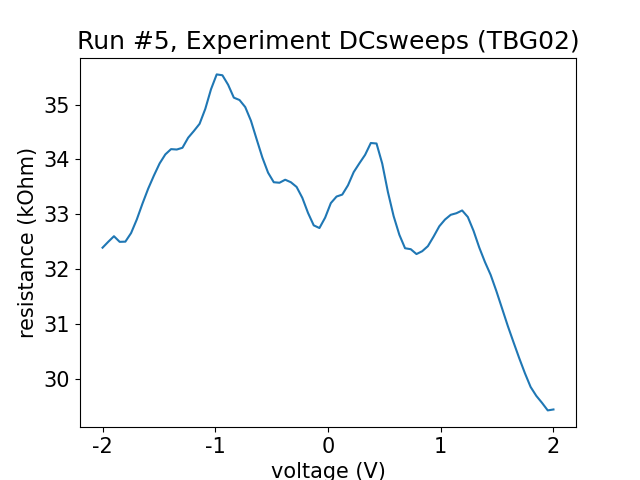

<IPython.core.display.Javascript object>


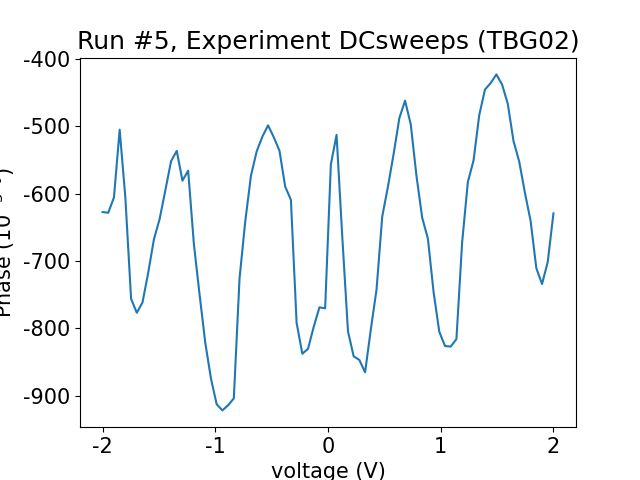

([<Axes: title={'center': 'Run #5, Experiment DCsweeps (TBG02)'}, xlabel='voltage (V)', ylabel='resistance (kOhm)'>,
  <Axes: title={'center': 'Run #5, Experiment DCsweeps (TBG02)'}, xlabel='voltage (V)', ylabel='Phase ($10^{-3}$ $\\degree$)'>],
 [None, None])

In [34]:
plot_dataset(dataset_24_11_sweep)

## HV Sweep

In [14]:
TBG02_exp_HV = load_or_create_experiment(
    experiment_name="HVsweeps",
    sample_name="TBG02"
)

In [22]:
# Setting up a doNd measurement
start = -30 ; stop = 30 ; dV = 0.5 ; N = int(abs(stop-start)//dV + 1) ; dt = 3
HVsweep1 = LinSweep(HVch.voltage, 0,     start, N//2, dt)
HVsweep2 = LinSweep(HVch.voltage, start, stop,  N, dt)
HVsweep3 = LinSweep(HVch.voltage, stop,  0,     N//2, dt)

print("Sweep will take : " + str(int(2*N*dt//60)) + " min " + str(int(2*N*dt%60)) + " s")

mfli4451.demods.timeconstant(dt)

Sweep will take : 12 min 6 s


Starting experimental run with id: 22. Using 'qcodes.dataset.dond'


  0%|          | 0/60 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


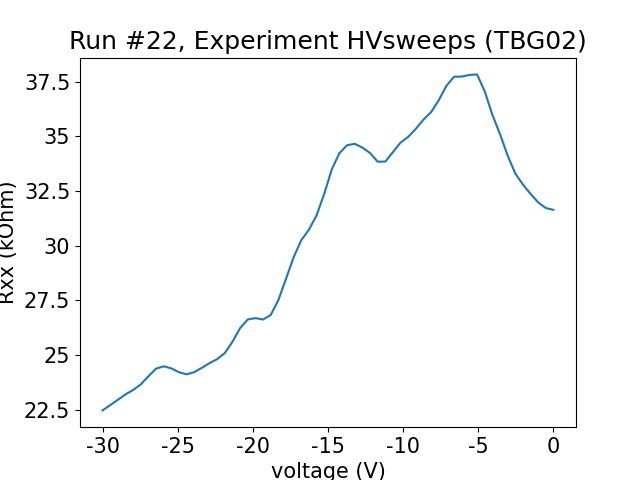

<IPython.core.display.Javascript object>


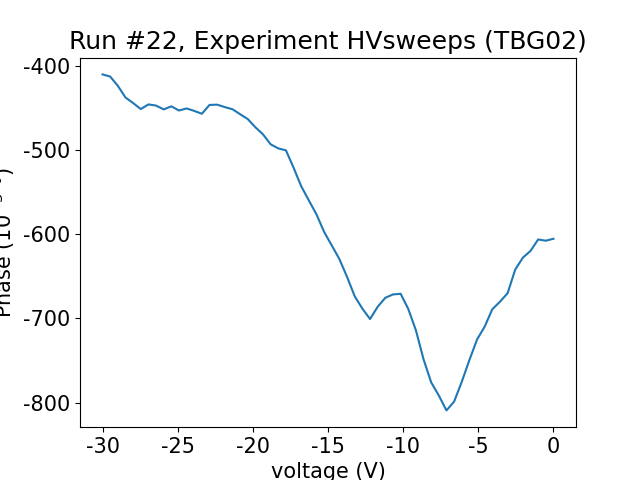

Starting experimental run with id: 23. Using 'qcodes.dataset.dond'


  0%|          | 0/121 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


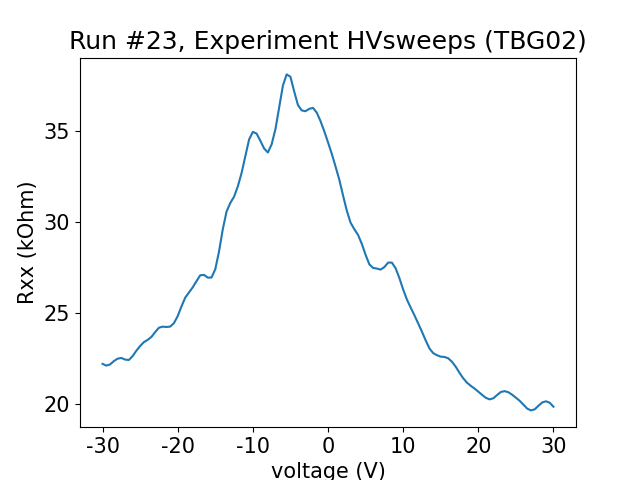

<IPython.core.display.Javascript object>


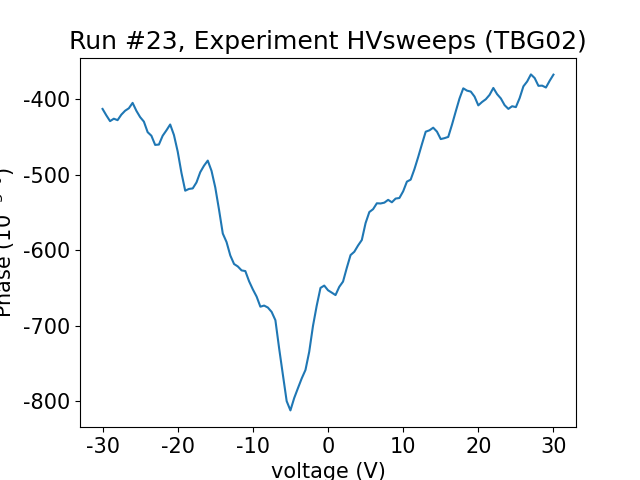

Starting experimental run with id: 24. Using 'qcodes.dataset.dond'


  0%|          | 0/60 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


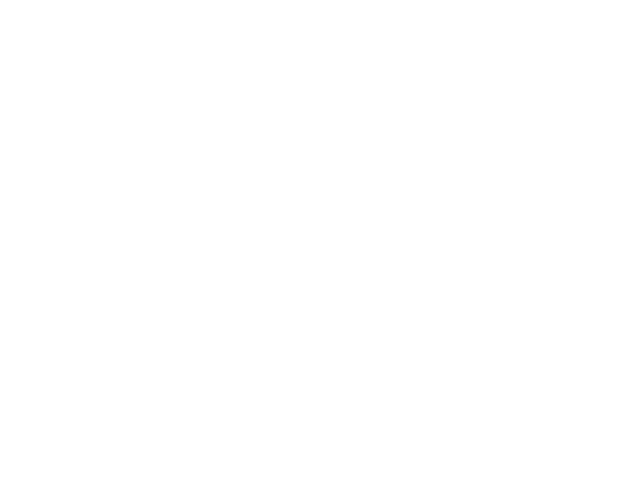

<IPython.core.display.Javascript object>


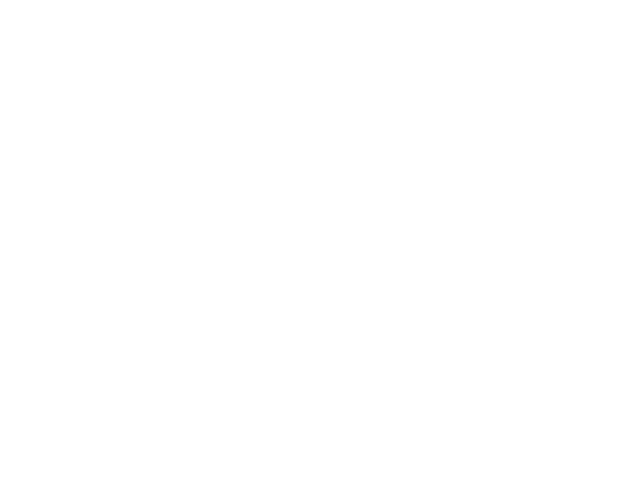

(HVsweep_24-11_30_0_3 #24@C:\Users\labo-admin\experiments.db
 -----------------------------------------------------------
 HV062_CH01_voltage - numeric
 Rxx - numeric
 zi_baseinstrument_dev4451_Vxx_phase - numeric,
 (<Axes: title={'center': 'Run #24, Experiment HVsweeps (TBG02)'}, xlabel='voltage (V)', ylabel='Rxx (kOhm)'>,
  <Axes: title={'center': 'Run #24, Experiment HVsweeps (TBG02)'}, xlabel='voltage (V)', ylabel='Phase ($10^{-3}$ $\\degree$)'>),
 (None, None))

In [23]:
# Go to the start point from 0
dond(
    HVsweep1,                             # 1st independent parameter
    Rxx,                           # 1st dependent parameter
    Vxx_phase,                         # 2nd dependent parameter
    measurement_name="HVsweep_24-11_0_-30_3",     # Set the measurement name
    exp=TBG02_exp_HV,                        # Set the experiment to save data to.
    show_progress=True,                   # Optional progress bar
    do_plot=True
)

#Sweeps
dond(
    HVsweep2,                             # 1st independent parameter
    Rxx,                           # 1st dependent parameter
    Vxx_phase,                         # 2nd dependent parameter
    measurement_name="HVsweep_24-11_-30_30_3",     # Set the measurement name
    exp=TBG02_exp_HV,                        # Set the experiment to save data to.
    show_progress=True,                   # Optional progress bar
    do_plot=True
)

# Go back to 0 from stop
dond(
    HVsweep3,                             # 1st independent parameter
    Rxx,                           # 1st dependent parameter
    Vxx_phase,                         # 2nd dependent parameter
    measurement_name="HVsweep_24-11_30_0_3",     # Set the measurement name
    exp=TBG02_exp_HV,                        # Set the experiment to save data to.
    show_progress=True,                   # Optional progress bar
    do_plot=True
)

In [51]:
HVch.voltage(2)

# Measure the resistance and temperature of the sample during cooling

In [ ]:
wait = 10 # Time between each measurement
jump = int(60 * 60/wait) # The graph only displays the time each 30 minutes
txt_file = "2024_06_12_4contacts_2-7_refroidissement_lecture.txt"
I = 10e-9

plt.ion()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize = (10,9), sharex = True)

Varray = np.array([]) ; VphaseArray = np.array([]) ; Iarray = np.array([]) ; IphaseArray = np.array([]) ; Tarray = np.array([]) ; t = np.array([]) ; tString = np.array([]) ; Rarray = np.array([])

line1, = ax1.plot(t, Varray/I, marker = "o")
line2, = ax2.plot(t, Tarray, marker = "o")

ax1.set_title("Resistance and temperature of the sample")
ax1.set_ylabel("Resistance ($\Omega$)")
ax2.set_ylabel("Temperature (K)")
ax2.set_xlabel("Time (s)")

ax1.ticklabel_format(useOffset=False)
ax2.ticklabel_format(useOffset=False)

legend_text1 = ax1.legend(['Resistance: N/A']).get_texts()[0]
legend_text2 = ax2.legend(['Temperature: N/A']).get_texts()[0]
ax1.grid(ls = "--", alpha = 0.5)
ax2.grid(ls = "--", alpha = 0.5)
plt.xticks(rotation=75)
#plt.tight_layout()

def init():
    line1.set_data([],[])
    line2.set_data([],[])
    return line1, line2

def update_plot(i):
    global Tarray, Varray, VphaseArray, Iarray, IphaseArray, Rarray, t, tString  # Declare variables as global
    
    V, Vphase = module_and_phase(mfli, 0)
    I, Iphase = module_and_phase(mfli, 1)
    T = calibration(dmm.amplitude())
    R = V/I
    Tarray = np.append(Tarray, T)
    Varray = np.append(Varray, V)
    VphaseArray = np.append(VphaseArray, Vphase)
    Iarray = np.append(Iarray, I)
    IphaseArray = np.append(IphaseArray, Iphase)
    Rarray = np.append(Rarray, R)

    timeObject = datetime.now()
    timeNowString = "%s:%s"%(timeObject.hour,timeObject.minute)
    tString = np.append(tString, timeNowString)
    t = np.append(t, i)
    
    line1.set_xdata(t)
    line1.set_ydata(Varray/10e-9)
    line2.set_xdata(t)
    line2.set_ydata(Tarray)
    
    legend_text1.set_text(f'Resistance = {V/I:.1f} ($\Omega$)')
    legend_text2.set_text(f'Temperature = {T:.3f} (K)')

    ax1.relim()
    ax1.autoscale_view()
    ax2.relim()
    ax2.autoscale_view()
    ax2.set_xticks(t[::jump], tString[::jump])

    with open(txt_file, "a") as f:
        f.write("%f \t %e \t %f \t %e \t %f \t %e \n"%(T, V, Vphase, I, Iphase, R))

    return line1, line2, legend_text1, legend_text2  # Return the modified artists

with open(txt_file, "a") as f:
    f.write("Temperature(K) \t Voltage(V) \t Voltage_Phase(deg) \t Current(A) \t Current_Phase(deg) \t Resistance(Ohms) \n")
    
# Create the animation
ani = FuncAnimation(fig, update_plot, init_func = init, cache_frame_data = False, interval = wait*1000, blit=True)
plt.show()

## Read the file created during cooling

In [18]:
N = 0
with open("2024_06_12_4contacts_2-7_refroidissement.txt", "r") as f:
    f.readline()
    for line in f.readlines():
        N += 1
print(N)

6810


In [19]:
T, V, Vp, I, Ip, R = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
vector = np.zeros(6)
with open("2024_06_12_4contacts_2-7_refroidissement.txt", "r") as f:
    n = len(f.readline().split())
    for line, i in zip(f.readlines(), range(N)):
        splitted = line.split()
        for j in range(n):
            vector[j] = float(splitted[j])
        T[i] = vector[0]
        V[i] = vector[1]
        Vp[i] = vector[2]
        I[i] = vector[3]
        Ip[i] = vector[4]
        R[i] = vector[5]

15.775352


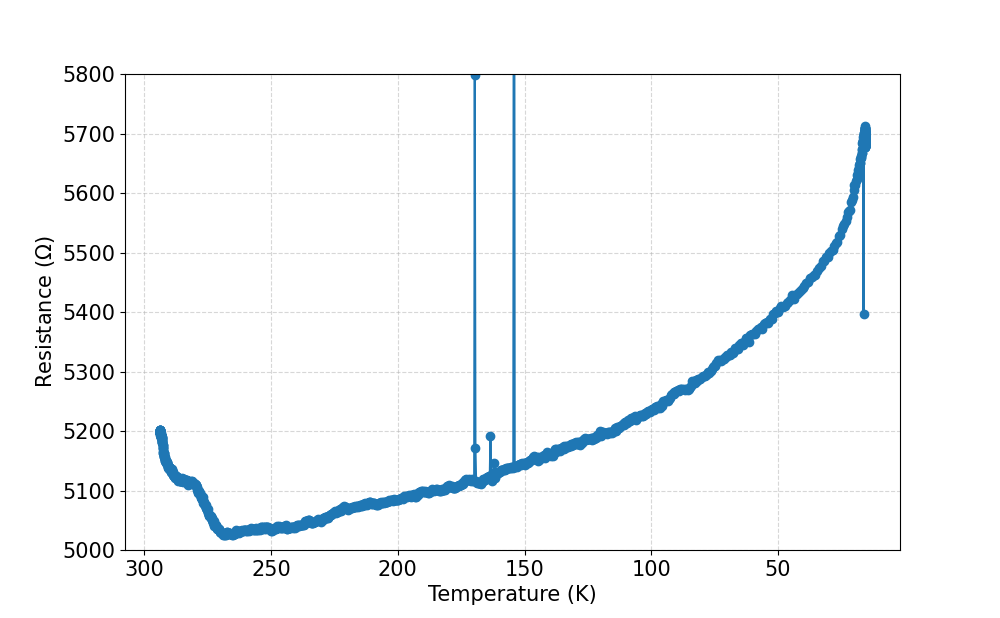

In [20]:
fig2, ax3 = plt.subplots(figsize = (10,6.18))

ax3.plot(T[:1500], V[:1500]/10e-9, marker = "o")
ax3.set_xlabel("Temperature (K)")
ax3.set_ylabel("Resistance ($\Omega$)")
ax3.set_ylim([5000, 5800])
print(T[1500])

ax3.grid(ls = "--", alpha = 0.5)
plt.gca().invert_xaxis()
#plt.savefig("Cooling_28K.png", dpi = 300)
plt.show()

weak localization model

# Read the temperature with the MFLI

In [ ]:
wait = 10  # Time between each measurement
jump = int(30 * 60 / wait)  # The graph only displays the time each 60 minutes
txt_file = "2023-11-22_TiN_Guillaume_cooling_MFLI.txt"

plt.ion()
fig3, ax4 = plt.subplots(figsize=(10, 6.18))

Varray = np.array([]); VphaseArray = np.array([]); Iarray = np.array([]); IphaseArray = np.array([]); Tarray = np.array([]); t = np.array([]); tString = np.array([]); Rarray = np.array([])

line4, = ax4.plot(t, Tarray, marker="o")

ax4.set_ylabel("Temperature (K)")
ax4.set_xlabel("Time (s)")
ax4.grid(alpha = 0.5, ls = "--")

ax4.ticklabel_format(useOffset=False)
plt.xticks(rotation=75)
plt.tight_layout()

# Add a legend with a placeholder text
legend_text = ax4.legend(['Temperature: N/A']).get_texts()[0]

def init():
    line4.set_data([],[])
    return line4

def update_plot(i):
    global Tarray, Varray, VphaseArray, Iarray, IphaseArray, Rarray, t, tString  # Declare variables as global
    
    V, Vphase = module_and_phase(mfli, 0)
    I, Iphase = module_and_phase(mfli, 1)
    R = V / I
    T = calibration(R)

    Tarray = np.append(Tarray, T)
    Varray = np.append(Varray, V)
    VphaseArray = np.append(VphaseArray, Vphase)
    Iarray = np.append(Iarray, I)
    IphaseArray = np.append(IphaseArray, Iphase)
    Rarray = np.append(Rarray, R)

    timeObject = datetime.now()
    timeNowString = "%s:%s" % (timeObject.hour, timeObject.minute)
    tString = np.append(tString, timeNowString)
    t = np.append(t, i)

    line4.set_xdata(t)
    line4.set_ydata(Tarray)
    legend_text.set_text(f'Temperature = {Tarray[-1]:.3f} (K)')

    ax4.relim()
    ax4.autoscale_view()
    ax4.set_xticks(t[::jump])
    ax4.set_xticklabels(tString[::jump])
    
    with open(txt_file, "a") as f:
        f.write("%f \t %e \t %f \t %e \t %f \t %e \n"%(T, V, Vphase, I, Iphase, R))

    return line4, legend_text

# Create the animation
with open(txt_file, "a") as f:
    f.write("Temperature(K) \t Voltage(V) \t Voltage_Phase(deg) \t Current(A) \t Current_Phase(deg) \t Resistance(Ohms) \n")
    
ani = FuncAnimation(fig3, update_plot, init_func = init, cache_frame_data = False, interval = wait*1000, blit=True)
plt.show()

# Sweep the gate voltage

Successfully reached 0.1 V


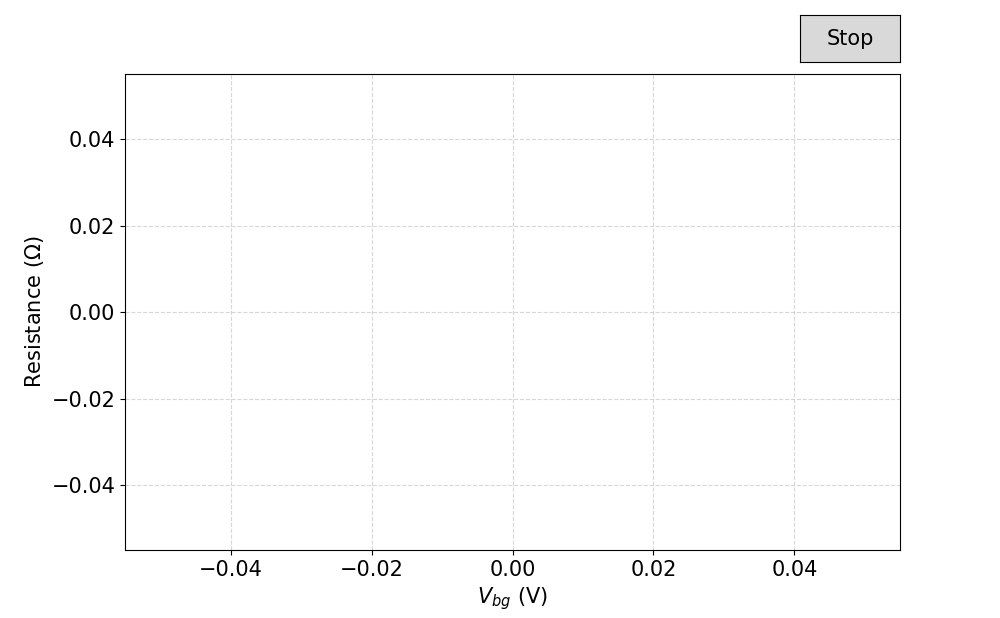

Error measuring data at step 88: ('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', "asking 'HV062 Q01' to <StahlHV: HV062>", 'getting HV062_CH01_voltage')


In [47]:
# Constants and initial setup
I = 10e-9  # 10 nA input
Vmin = 100
Vmax = 0
step = 1

if Vmin>Vmax : 
    buf = Vmin
    Vmin = Vmax
    Vmax = buf
    Vbg = np.flip(np.arange(Vmin, Vmax + step, step))# Stahl voltage source typically has an offset error of 1.5mV
else : Vbg = np.arange(Vmin, Vmax + step, step) 
N = np.size(Vbg)
VbgMeasured = np.zeros(N) #Stahl voltmeter typically has an error of 0.1V
wait = 2  # Time between each measurement in seconds
txt_file = "2024-06-21_50_0_16k_2vstep.txt"
groundingWhenFinished = False

# Initialize empty arrays to store data
Varray, VphaseArray = np.zeros(N), np.zeros(N)
Iarray, IphaseArray = np.zeros(N), np.zeros(N)
Tarray = np.zeros(N)
Varray2, VphaseArray2 = np.zeros(N), np.zeros(N)
Vleak = np.zeros(N)

# Create a figure and axis
fig5, ax5 = plt.subplots(figsize=(10, 6.18))
ax5.set_ylabel("Resistance ($\Omega$)")
ax5.set_xlabel("$V_{bg}$ (V)")
ax5.grid(alpha=0.5, ls="--")

# Initialize plot elements (empty plot initially)
line5, = ax5.plot([], [], marker="o")
line6, = ax5.plot([], [], marker="o")

# Open text file for writing initial information
with open(txt_file, "a") as f:
    f.write(f"Time between each measurement : {wait} s \n")
    f.write("Vbg(V) \t VbgMeasured(V) \t Voltage(V) \t Voltage_Phase(deg) \t Voltage2(V) \t Voltage_Phase2(deg) \t Current(A) \t Current_Phase(deg) \t Temperature(K) \t Vleak(V) \n")

def init():
    line5.set_data([],[])
    line6.set_data([],[])
    return line5,line6
    
# Function to update the plot
def update_plot(i): 
    # Set voltage and wait
    ch1.voltage(Vbg[i])
    time.sleep(wait)
    
    # Measure data
    try:
        Varray[i], VphaseArray[i] = module_and_phase(mfli, 0)
        Iarray[i], IphaseArray[i] = module_and_phase(mfli, 1)
        Tarray[i] = calibration(dmm.amplitude())
        Varray2[i], VphaseArray2[i] = module_and_phase(mfli2, 0)
        VbgMeasured[i] = ch1.voltage()
    except Exception as e:
        print(f"Error measuring data at step {i}: {e}")
        return line5, line6
    
    # Update plot data
    line5.set_data(Vbg[:i+1], Varray[:i+1] / I)
    line6.set_data(Vbg[:i+1], Varray2[:i+1] / I)
    ax5.relim()
    ax5.autoscale_view()
    
    # Update plot title with useful information
    fig5.suptitle(f'$T$ = {Tarray[i]:.3f} K ; $V_g$ = {Vbg[i]:.1f} V ; $R$ = {Varray[i] / I:.1f} $\Omega$ ; $I_l$ = {Vleak[i]/1e9:1f} A')

    # Append data to text file
    with open(txt_file, "a") as f:
        f.write("%f \t %f \t %e \t %f \t %e \t %f \t %e \t %f \t %f \n" % (Vbg[i], VbgMeasured[i], Varray[i], VphaseArray[i], Varray2[i], VphaseArray2[i], Iarray[i], IphaseArray[i], Tarray[i]))

    # Ground voltage when the sweep is done
    if groundingWhenFinished and i == N-1: 
        goToGround(ch1, start=Vmax, fastStep=0.1, fastWait=0.5)

    return line5, line6

# Create tqdm instance for progress bar 
# progress_bar = tqdm(total=N, desc='Progress', position=0)

# Function to update tqdm progress bar
# def update_progress(*args):
#     progress_bar.update(1)

goToVoltage(ch1, start=ch1.voltage(), stop=Vmin, fastStep=0.1, fastWait=0.5)

# Create animation
ani = FuncAnimation(fig5, update_plot, init_func = init, cache_frame_data = True, interval = 100, blit=True, frames = N, repeat = False)
# ani.event_source.add_callback(update_progress)

def stop_animation(event):
    ani.event_source.stop()
    print("Sweep has been stopped")

# Create a button and set its position
ax_button = plt.axes([0.8, 0.9, 0.1, 0.075])
button = Button(ax_button, 'Stop')

# Attach the stop function to the button
button.on_clicked(stop_animation)

plt.show()


In [14]:
goToGround(ch1, start=ch1.voltage(), fastStep=0.1, fastWait=0.5)

VisaIOError: ('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', "asking 'HV062 Q01' to <StahlHV: HV062>", 'getting HV062_CH01_voltage')

[6.324712e-05, 6.338153e-05, 6.40742e-05, 6.540153e-05, 6.699859e-05, 6.839816e-05, 6.936059e-05, 7.037587e-05, 7.147903e-05, 7.280523e-05, 7.466517e-05, 7.684507e-05, 7.919932e-05, 8.090063e-05, 8.21282e-05, 8.306674e-05, 8.428613e-05, 8.613102e-05, 8.829298e-05, 9.032963e-05, 9.221395e-05, 9.425218e-05, 9.646463e-05, 9.873671e-05, 0.0001007007, 0.00010119]


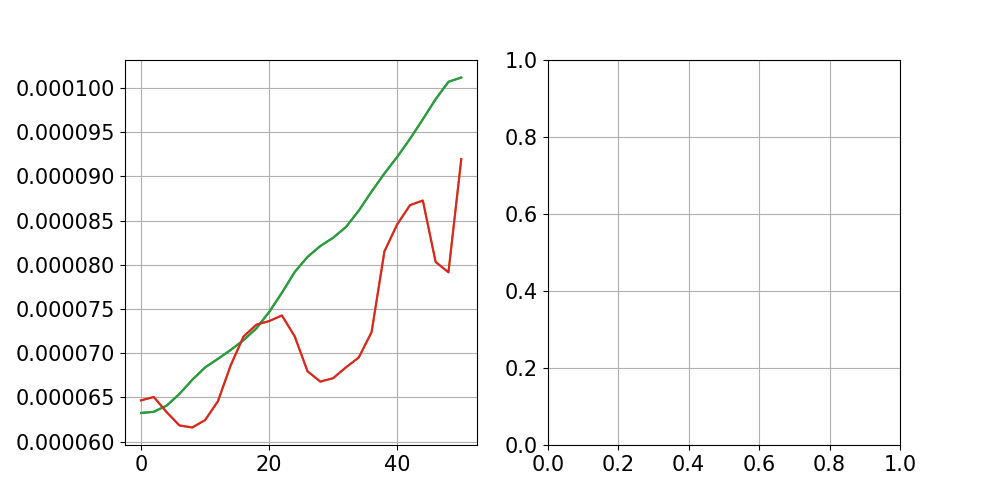

In [45]:
with open("2024-06-21_0_50_16k_2vstep.txt", 'r') as file :
    lines=file.readlines()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

x= []
y1 = []
y2 = []

for line in lines[2:] :
    line = line.split("\t")
    x.append(float(line[0].strip()))
    y1.append(float(line[2].strip()))
    y2.append(float(line[4].strip()))

print(y1)
ax.plot(x,y1)
ax.plot(x,y2)

ax.grid()

with open("2024-06-21_0_50_16k_2vstep.txt", 'r') as file :
    lines=file.readlines()

x= []
y1 = []
y2 = []

for line in lines[2:] :
    line = line.split("\t")
    x.append(float(line[0].strip()))
    y1.append(float(line[2].strip()))
    y2.append(float(line[4].strip()))

ax.plot(x,y1)
ax.plot(x,y2)

ax1.grid()

plt.show()




In [36]:
goToVoltage(bgChannel=ch1,stop=20, start=ch1.voltage(), fastStep=0.5)

Successfully reached 10.2 V


In [35]:
ch1.voltage(0)

In [ ]:
loc = "15-22"
with open("Log_manual.txt", "a") as f:
    V, Phi_V = module_and_phase(mfli, 0)
    f.write(f"Contacts {loc} : {V} \t {Phi_V} \t {V/1e-8} \n")

In [51]:
ani.event_source.stop()

In [48]:
calibration(dmm.amplitude())

36.254677622168835

# Hysteresis

Successfully reached 0.1 V


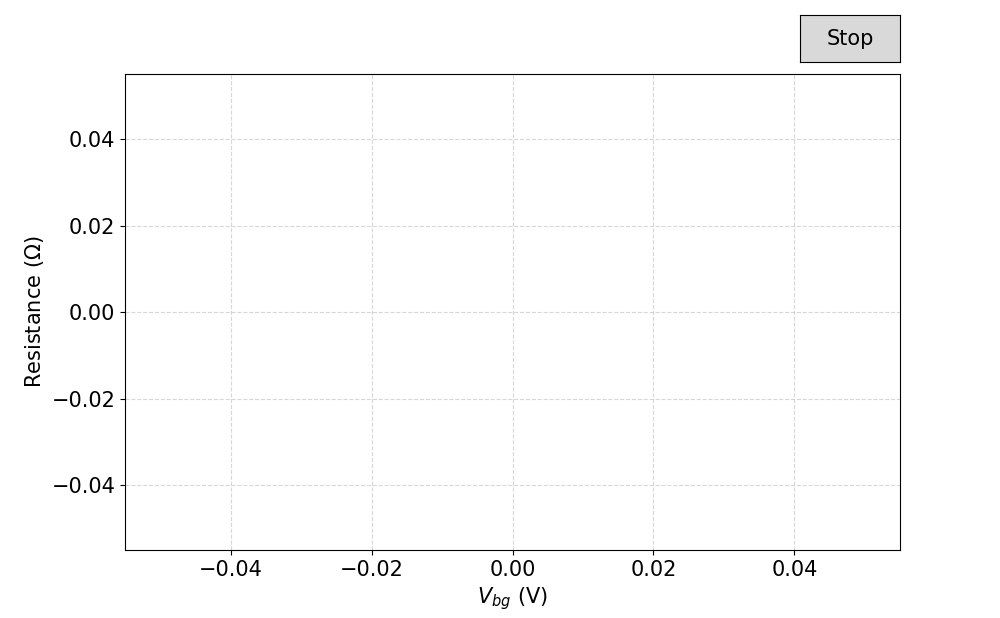

Successfully reached 0.1 V


In [368]:
# Constants and initial setup
I = 10e-9  # 10 nA input
Vmin = 0
Vmax = 200
step = 0,5

Vbg = np.concatenate([np.arange(Vmin, Vmax + step, step) ,np.flip(np.arange(Vmin, Vmax + step, step))])
N = np.size(Vbg)
VbgMeasured = np.zeros(N) #Stahl voltmeter typically has an error of 0.1V
wait = 4  # Time between each measurement in seconds
txt_file = "24062024\\2024-06-25_Hyst_0_200_0,5_15k_3s.txt"
groundingWhenFinished = True

# Initialize empty arrays to store data
Varray, VphaseArray = np.zeros(N), np.zeros(N)
Iarray, IphaseArray = np.zeros(N), np.zeros(N)
Tarray = np.zeros(N)
Varray2, VphaseArray2 = np.zeros(N), np.zeros(N)
Vleak = np.zeros(N)

# Create a figure and axis
fig5, ax5 = plt.subplots(figsize=(10, 6.18))
ax5.set_ylabel("Resistance ($\Omega$)")
ax5.set_xlabel("$V_{bg}$ (V)")
ax5.grid(alpha=0.5, ls="--")

# Initialize plot elements (empty plot initially)
line5, = ax5.plot([], [], marker="o")
line6, = ax5.plot([], [], marker="o")

# Open text file for writing initial information
with open(txt_file, "a") as f:
    f.write(f"Time between each measurement : {wait} s \n")
    f.write("Vbg(V) \t VbgMeasured(V) \t Voltage(V) \t Voltage_Phase(deg) \t Voltage2(V) \t Voltage_Phase2(deg) \t Current(A) \t Current_Phase(deg) \t Temperature(K) \t Vleak(V) \n")

def init():
    line5.set_data([],[])
    line6.set_data([],[])
    return line5,line6
    
# Function to update the plot
def update_plot(i): 
    # Set voltage and wait
    ch1.voltage(Vbg[i])
    time.sleep(wait)
    
    # Measure data
    try:
        Varray[i], VphaseArray[i] = module_and_phase(mfli, 0)
        Iarray[i], IphaseArray[i] = module_and_phase(mfli, 1)
        Tarray[i] = calibration(dmm.amplitude())
        Varray2[i], VphaseArray2[i] = module_and_phase(mfli2, 0)
        VbgMeasured[i] = ch1.voltage()
    except Exception as e:
        print(f"Error measuring data at step {i}: {e}")
        return line5, line6
    
    # Update plot data
    line5.set_data(Vbg[:i+1], Varray[:i+1] / I)
    line6.set_data(Vbg[:i+1], Varray2[:i+1] / I)
    ax5.relim()
    ax5.autoscale_view()
    
    # Update plot title with useful information
    fig5.suptitle(f'$T$ = {Tarray[i]:.3f} K ; $V_g$ = {Vbg[i]:.1f} V ; $R$ = {Varray[i] / I:.1f} $\Omega$')

    # Append data to text file
    with open(txt_file, "a") as f:
        f.write("%f \t %f \t %e \t %f \t %e \t %f \t %e \t %f \t %f \n" % (Vbg[i], VbgMeasured[i], Varray[i], VphaseArray[i], Varray2[i], VphaseArray2[i], Iarray[i], IphaseArray[i], Tarray[i]))

    # Ground voltage when the sweep is done
    if groundingWhenFinished and i == N-1: 
        goToGround(ch1, start=Vmax, fastStep=0.1, fastWait=0.5)

    return line5, line6

# Create tqdm instance for progress bar 
# progress_bar = tqdm(total=N, desc='Progress', position=0)

# Function to update tqdm progress bar
# def update_progress(*args):
#     progress_bar.update(1)

goToVoltage(ch1, start=ch1.voltage(), stop=Vmin, fastStep=0.1, fastWait=0.5)

# Create animation
ani = FuncAnimation(fig5, update_plot, init_func = init, cache_frame_data = True, interval = 100, blit=True, frames = N, repeat = False)
# ani.event_source.add_callback(update_progress)

def stop_animation(event):
    ani.event_source.stop()
    print("Sweep has been stopped")

# Create a button and set its position
ax_button = plt.axes([0.8, 0.9, 0.1, 0.075])
button = Button(ax_button, 'Stop')

# Attach the stop function to the button
button.on_clicked(stop_animation)

plt.show()

# Delay + Hysteresis

Successfully reached 0.0 V


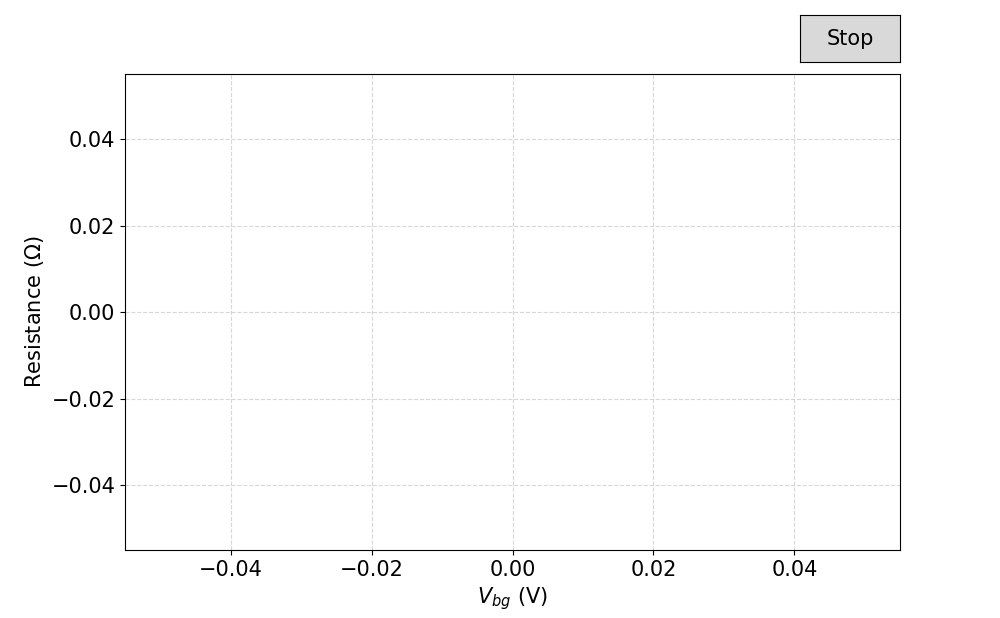

Error measuring data at step 36: ('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', "asking 'HV062 Q01' to <StahlHV: HV062>", 'getting HV062_CH01_voltage')
Error measuring data at step 189: ('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', "asking 'HV062 Q01' to <StahlHV: HV062>", 'getting HV062_CH01_voltage')
Error measuring data at step 295: ('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', "asking 'HV062 Q01' to <StahlHV: HV062>", 'getting HV062_CH01_voltage')
Successfully reached 0.1 V


In [367]:
# Constants and initial setup
time.sleep(3600*10)

I = 10e-9  # 10 nA input
Vmin = 0
Vmax = 150
step = 0.500

Vbg = np.concatenate([np.arange(Vmin, Vmax + step, step) ,np.flip(np.arange(Vmin, Vmax + step, step))])
N = np.size(Vbg)
VbgMeasured = np.zeros(N) #Stahl voltmeter typically has an error of 0.1V
wait = 3  # Time between each measurement in seconds
txt_file = "24062024\\2024-06-24_Hyst_0_150_0,5_16k_3s.txt" 
groundingWhenFinished = True

# Initialize empty arrays to store data
Varray, VphaseArray = np.zeros(N), np.zeros(N)
Iarray, IphaseArray = np.zeros(N), np.zeros(N)
Tarray = np.zeros(N)
Varray2, VphaseArray2 = np.zeros(N), np.zeros(N)
Vleak = np.zeros(N)

# Create a figure and axis
fig5, ax5 = plt.subplots(figsize=(10, 6.18))
ax5.set_ylabel("Resistance ($\Omega$)")
ax5.set_xlabel("$V_{bg}$ (V)")
ax5.grid(alpha=0.5, ls="--")

# Initialize plot elements (empty plot initially)
line5, = ax5.plot([], [], marker="o")
line6, = ax5.plot([], [], marker="o")

# Open text file for writing initial information
with open(txt_file, "a") as f:
    f.write(f"Time between each measurement : {wait} s \n")
    f.write("Vbg(V) \t VbgMeasured(V) \t Voltage(V) \t Voltage_Phase(deg) \t Voltage2(V) \t Voltage_Phase2(deg) \t Current(A) \t Current_Phase(deg) \t Temperature(K) \t Vleak(V) \n")

def init():
    line5.set_data([],[])
    line6.set_data([],[])
    return line5,line6
    
# Function to update the plot
def update_plot(i): 
    # Set voltage and wait
    ch1.voltage(Vbg[i])
    time.sleep(wait)
    
    # Measure data
    try:
        Varray[i], VphaseArray[i] = module_and_phase(mfli, 0)
        Iarray[i], IphaseArray[i] = module_and_phase(mfli, 1)
        Tarray[i] = calibration(dmm.amplitude())
        Varray2[i], VphaseArray2[i] = module_and_phase(mfli2, 0)
        VbgMeasured[i] = ch1.voltage()
    except Exception as e:
        print(f"Error measuring data at step {i}: {e}")
        return line5, line6
    
    # Update plot data
    line5.set_data(Vbg[:i+1], Varray[:i+1] / I)
    line6.set_data(Vbg[:i+1], Varray2[:i+1] / I)
    ax5.relim()
    ax5.autoscale_view()
    
    # Update plot title with useful information
    fig5.suptitle(f'$T$ = {Tarray[i]:.3f} K ; $V_g$ = {Vbg[i]:.1f} V ; $R$ = {Varray[i] / I:.1f} $\Omega$')

    # Append data to text file
    with open(txt_file, "a") as f:
        f.write("%f \t %f \t %e \t %f \t %e \t %f \t %e \t %f \t %f \n" % (Vbg[i], VbgMeasured[i], Varray[i], VphaseArray[i], Varray2[i], VphaseArray2[i], Iarray[i], IphaseArray[i], Tarray[i]))

    # Ground voltage when the sweep is done
    if groundingWhenFinished and i == N-1: 
        goToGround(ch1, start=Vmax, fastStep=0.1, fastWait=0.5)

    return line5, line6

# Create tqdm instance for progress bar 
# progress_bar = tqdm(total=N, desc='Progress', position=0)

# Function to update tqdm progress bar
# def update_progress(*args):
#     progress_bar.update(1)

goToVoltage(ch1, start=ch1.voltage(), stop=Vmin, fastStep=0.1, fastWait=0.5)

# Create animation
ani = FuncAnimation(fig5, update_plot, init_func = init, cache_frame_data = True, interval = 100, blit=True, frames = N, repeat = False)
# ani.event_source.add_callback(update_progress)

def stop_animation(event):
    ani.event_source.stop()
    print("Sweep has been stopped")

# Create a button and set its position
ax_button = plt.axes([0.8, 0.9, 0.1, 0.075])
button = Button(ax_button, 'Stop')

# Attach the stop function to the button
button.on_clicked(stop_animation)

plt.show()